# Transformaciones No Lineales

## Introducción

Antes de introducir los métodos kernel y sus propiedades, consideremos dos ejemplos que ilustran cómo se pueden manejar las fronteras de decisión no lineales mediante la transformación de los vectores de características $\mathbf{x}_n$ en dimensiones superiores y realizando la tarea de aprendizaje en el dominio transformado. Denotaremos tales transformaciones genéricamente por la notación:

$$
\mathbf{x}_n \in \mathbb{R}^M \rightarrow \phi(\mathbf{x}_n) \in \mathbb{R}^{M'}
$$

donde la dimensión del nuevo espacio ampliado se denota por $M'$. La función $\phi(\cdot)$ actúa sobre las entradas individuales de $\mathbf{x}_n$ para generar un nuevo vector de tamaño $M'$. A veces, denotaremos el vector de características transformado por la notación $\mathbf{z}_n$, es decir,

$$
\mathbf{z}_n = \phi(\mathbf{x}_n)
$$


## Ejemplo clásico

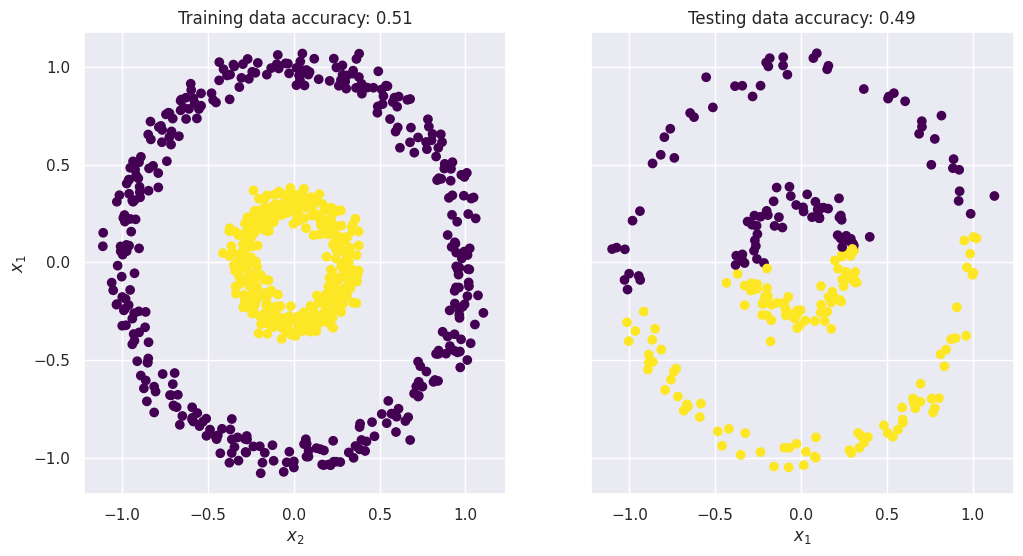

In [1]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import seaborn as sns

sns.set_theme()

X, y = make_circles(n_samples=1_000, factor=0.3, noise=0.05, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_predict = clf.predict(X_test)
train_accuracy = clf.score(X_train, y_train)

clf.predict_proba(X_test)
test_accuracy = clf.score(X_test, y_test)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12, 6), dpi=100)

ax1.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="viridis")
ax1.set_ylabel(r"$x_1$")
ax1.set_xlabel(r"$x_2$")
ax1.set_title(f"Training data accuracy: {train_accuracy:.2f}")

ax2.scatter(X_test[:, 0], X_test[:, 1], c=y_predict, cmap="viridis")
ax2.set_xlabel(r"$x_1$")
ax2.set_title(f"Testing data accuracy: {test_accuracy:.2f}")

plt.show()


## Curva de Separación No Lineal

Consideremos la situación ilustrada en la donde los datos de características están separados por una curva elíptica. Una forma de transformar este problema en un escenario que implique determinar un hiperplano de separación en dimensiones superiores (en lugar de una elipse en dos dimensiones) es extendiendo los vectores de características.

Denotamos las entradas del vector de características $\mathbf{x}$ genéricamente por:

$$
\mathbf{x} = [1, x, y]^T
$$

donde el número 1 se ha añadido para el término constante; además, los escalares $(x, y)$ denotan las coordenadas del punto correspondiente a $\mathbf{x}$ en $\mathbb{R}^2$. Si buscáramos una línea de separación con vector normal

$$
\mathbf{w}^{*} = [-\theta^*, a*, b*]^T
$$

entonces todos los puntos en esta línea satisfarían la ecuación $\mathbf{x}^T \mathbf{w}^* = 0$ o, de manera equivalente,

$$
a^* x + b^* y = \theta^*
$$

Sabemos que no existe una línea de separación de este tipo para los datos mostrados en la figura. Los datos sugieren que deberíamos buscar una curva elíptica en $\mathbb{R}^2$. Para transformar la tarea de determinar tal curva no lineal en un problema equivalente que implique la determinación de un hiperplano en dimensiones superiores, extendemos el vector de características añadiendo términos de segundo orden y definiendo:

$$
\mathbf{z} = \phi(\mathbf{x}) = [1, x, y, xy, x^2, y^2]^T
$$

Esta transformación mapea los datos originales $(x, y) \in \mathbb{R}^2$ en el espacio ampliado de cinco dimensiones $(x, y, xy, x^2, y^2) \in \mathbb{R}^5$. Si ahora resolvemos el problema de clasificación binaria en este dominio ampliado y determinamos un hiperplano de separación, $\mathbf{w}^\phi$, digamos, con parámetros:

$$
\mathbf{w}^\phi = [-\theta^\phi, a^\phi, b^\phi, c^\phi, d^\phi, e^\phi]^T
$$

entonces los puntos que se encuentran en este hiperplano satisfarían la ecuación:

$$
a^\phi x + b^\phi y + c^\phi xy + d^\phi x^2 + e^\phi y^2 = \theta^\phi
$$

que es la ecuación general de una elipse en $\mathbb{R}^2$. Los resultados de clasificación se pueden obtener realizando las comparaciones:

$$
\begin{cases}
\text{si } (\mathbf{z})^T \mathbf{w}^\phi < 0, \text{ asignar } \mathbf{x} \text{ a la clase } -1 \\
\text{si } (\mathbf{z})^T \mathbf{w}^\phi \geq 0, \text{ asignar } \mathbf{x} \text{ a la clase } +1
\end{cases}
$$

De esta manera, al extender la dimensión del espacio de características, podemos transformar el problema de clasificación en uno que involucra un clasificador lineal de la forma anterior.


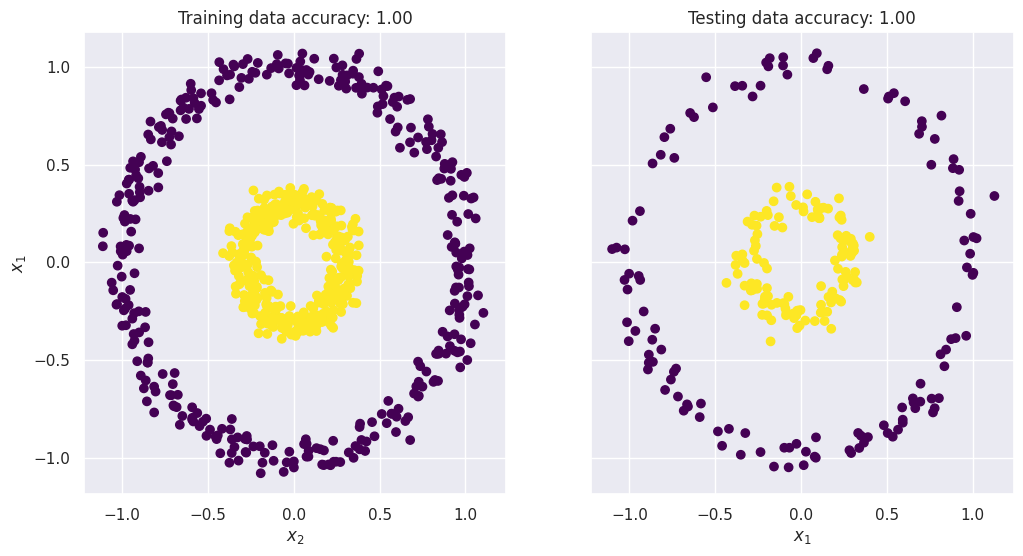

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

class CustomPolynomialFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, include_bias=True):
        self.include_bias = include_bias

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.include_bias:
            ones = np.ones((X.shape[0], 1))
            x1 = X[:, 0:1]
            x2 = X[:, 1:2]
            x1x2 = x1 * x2
            x1_square = x1 ** 2
            x2_square = x2 ** 2
            return np.hstack((ones, x1, x2, x1x2, x1_square, x2_square))
        else:
            x1 = X[:, 0:1]
            x2 = X[:, 1:2]
            x1x2 = x1 * x2
            x1_square = x1 ** 2
            x2_square = x2 ** 2
            return np.hstack((x1, x2, x1x2, x1_square, x2_square))

# Ejemplo de uso en un pipeline

# Crear el pipeline
pipeline = Pipeline([
        ('poly_features', CustomPolynomialFeatures(include_bias=False)),
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(random_state=0))
])

# Entrenar el modelo
pipeline.fit(X_train, y_train)

y_predict = pipeline.predict(X_test)

# Evaluar el modelo
train_accuracy = pipeline.score(X_train, y_train)
test_accuracy = pipeline.score(X_test, y_test)

# Graficar datos de entrenamiento
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12, 6), dpi=100)
scatter1 = ax1.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="viridis")
ax1.set_ylabel(r"$x_1$")
ax1.set_xlabel(r"$x_2$")
ax1.set_title(f"Training data accuracy: {train_accuracy:.2f}")

# Graficar datos de prueba
scatter2 = ax2.scatter(X_test[:, 0], X_test[:, 1], c=y_predict, cmap="viridis")
ax2.set_xlabel(r"$x_1$")
ax2.set_title(f"Testing data accuracy: {test_accuracy:.2f}")

plt.show()



### Conclusión

La extensión del espacio de características mediante transformaciones no lineales permite convertir problemas de clasificación no lineales en problemas de clasificación lineales en el espacio ampliado. Sin embargo, un desafío clave es que, en general, no conocemos de antemano la forma analítica de la curva no lineal que separa los datos de entrenamiento, lo que dificulta decidir de antemano qué extensión de la forma anterior debe usarse. Es por eso que los métodos basados en kernels proporcionan una forma “automatizada” de extender el espacio de características, permitiendo al algoritmo de aprendizaje seleccionar autónomamente una extensión adecuada.